In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import sys

sys.path.insert(0, r'/content/gdrive/My Drive/depth estimation')

In [3]:
import torch
import torch.nn as nn
from unet import ResNetUNet
from dataset import DepthMapDataset, DepthMapDataLoader
import matplotlib.pyplot as plt


In [4]:
dataset = DepthMapDataset(r'/content/gdrive/My Drive/mini-dataset')
dataloader = DepthMapDataLoader(dataset=dataset, batch_size=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
model = ResNetUNet()
model = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
optimizer.zero_grad()

criterion = torch.nn.MSELoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


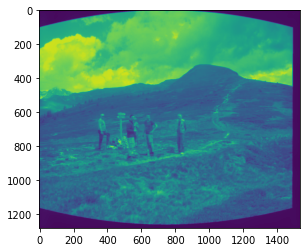

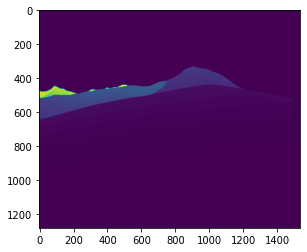

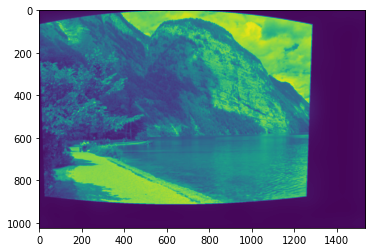

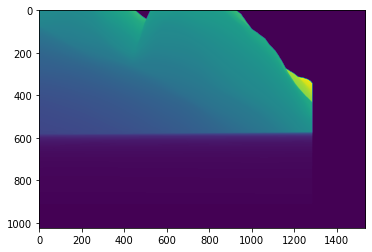

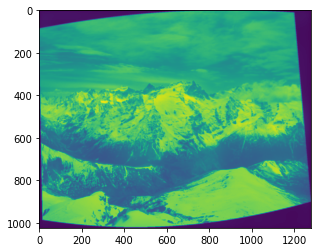

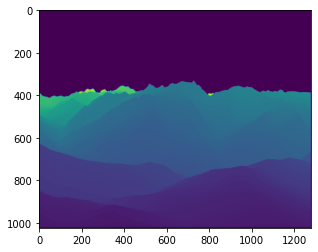

13159209.463541666
13136356.270833334
13085159.713541666
12816652.583333334
12507324.1875
11768175.252604166
10482257.8125
8981970.6875
8076488.583333333
7695005.75


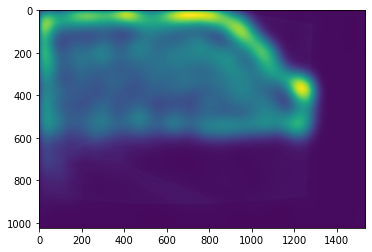

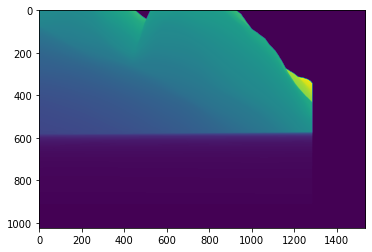

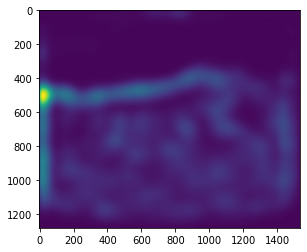

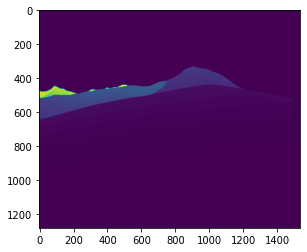

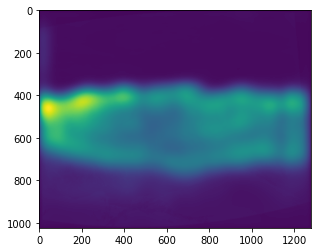

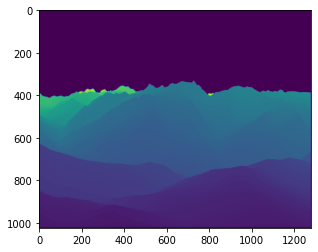

7625882.416666667
7007003.416666667
6439082.583333333
6191927.916666667
5290860.666666667
4380442.5
3606607.0833333335
2902574.8333333335
2719866.875
2342648.75


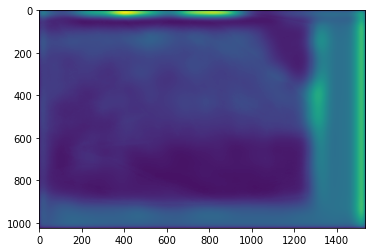

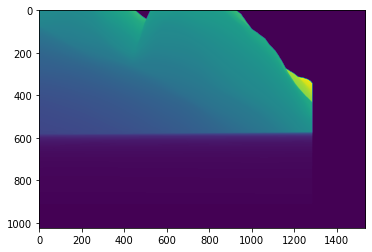

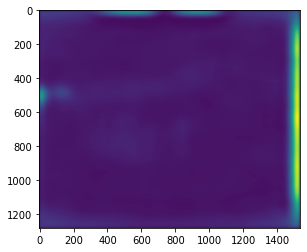

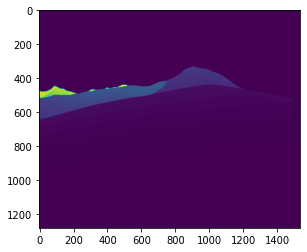

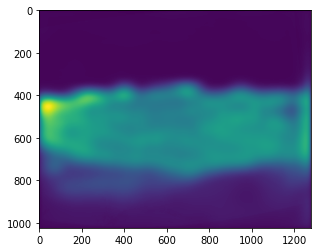

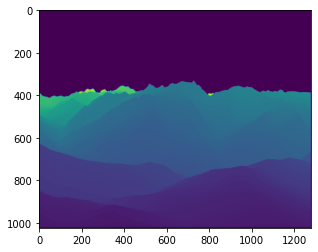

2156899.25
1501040.1354166667
1393022.6875
995766.9583333334
944920.7994791666
847479.3880208334
833187.9296875
741836.0416666666
682690.2408854166
702048.72265625


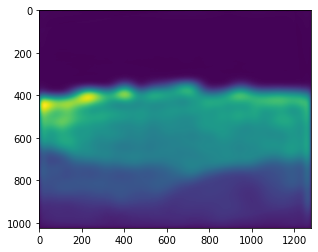

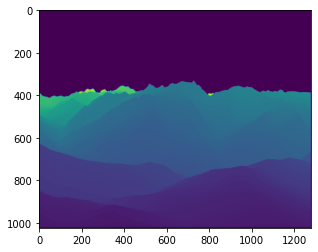

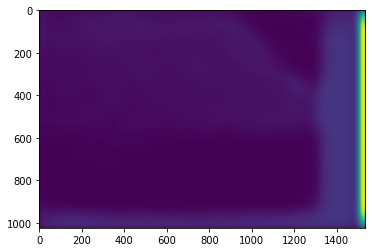

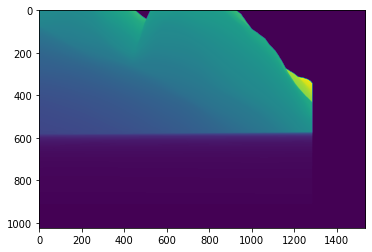

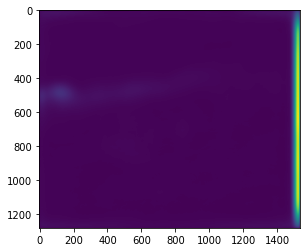

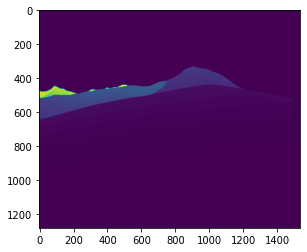

668032.04296875
626528.8997395834
638120.0494791666
599973.8125
590290.7669270834
585816.828125
573185.8111979166
571101.78125
562621.9811197916
554096.3235677084


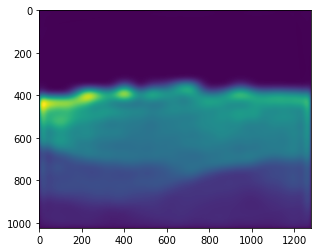

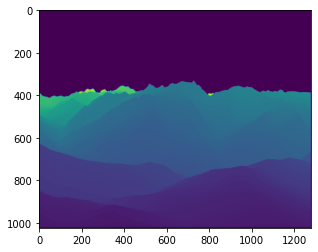

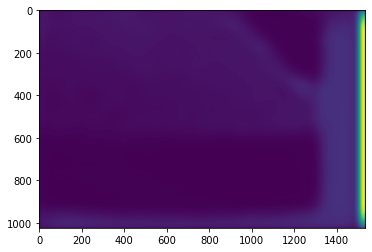

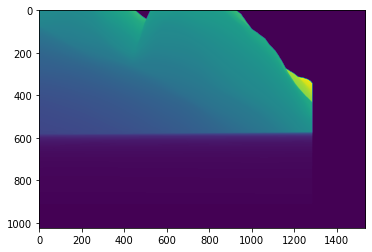

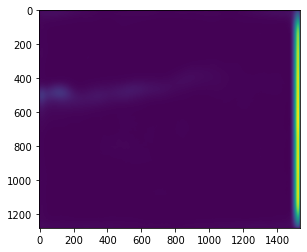

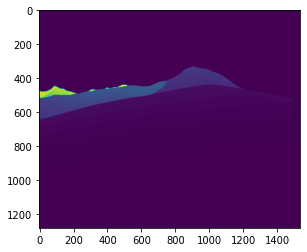

550419.201171875
549773.654296875
541056.228515625
542626.7220052084
537399.916015625
533658.7955729166
530740.671875
524745.091796875
521614.49609375
519366.9459635417


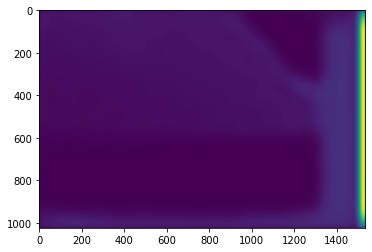

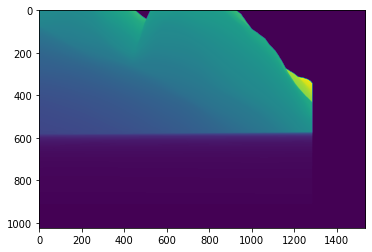

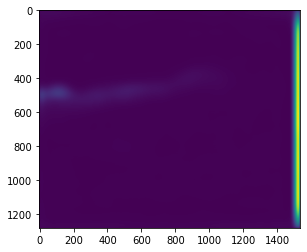

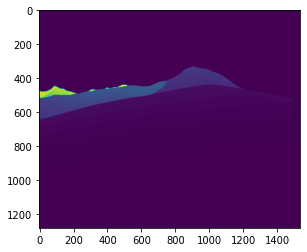

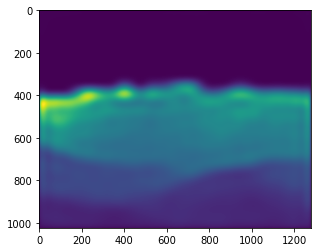

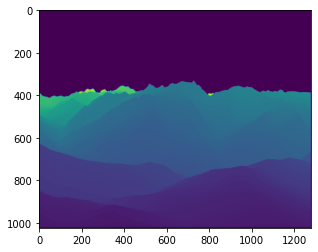

515979.158203125
513687.0091145833
513220.3990885417
508543.1549479167
505978.3977864583
504842.787109375
501722.1653645833
499658.1126302083
498094.638671875
494994.9192708333


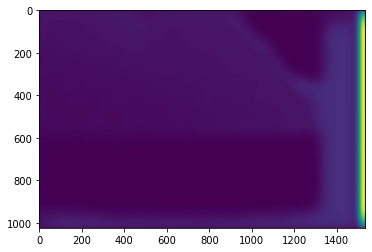

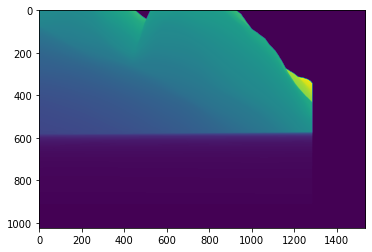

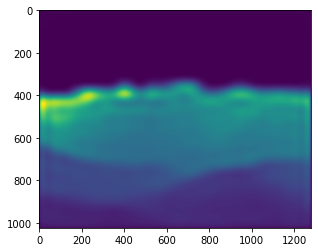

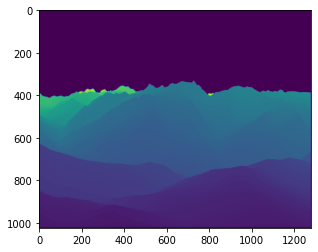

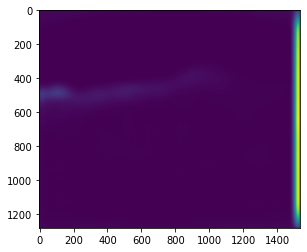

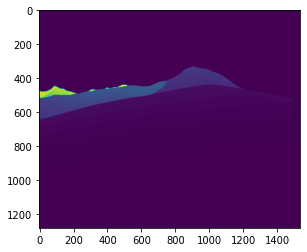

493866.8268229167
495894.365234375
492071.5442708333
490793.6243489583
500117.8515625
517957.9446614583
491296.201171875
713335.4505208334
580972.3580729166
585368.578125


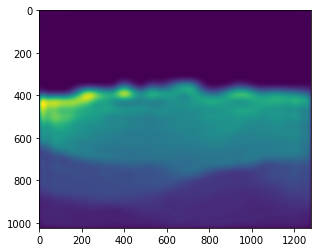

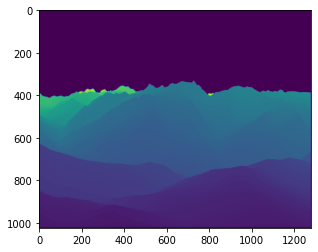

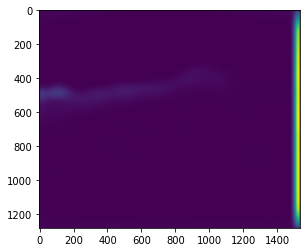

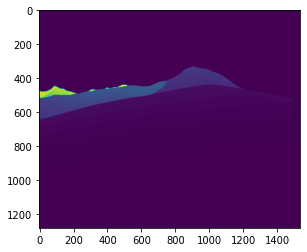

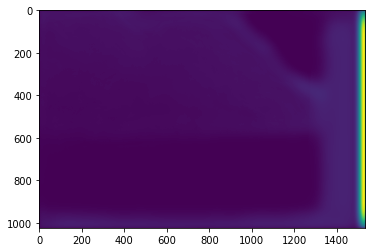

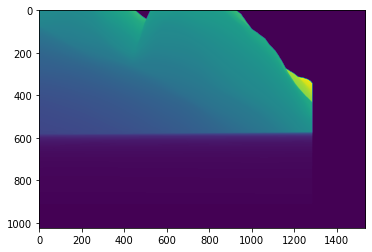

540079.7291666666
530147.0859375
502875.8046875
495036.6536458333
493279.6770833333
484216.0859375
498285.5859375
487074.14453125
482333.6256510417
478823.451171875


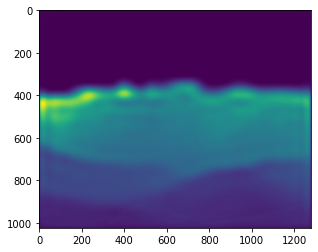

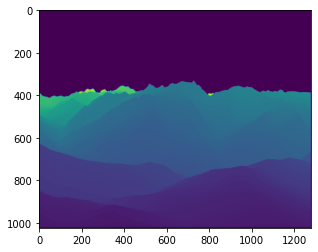

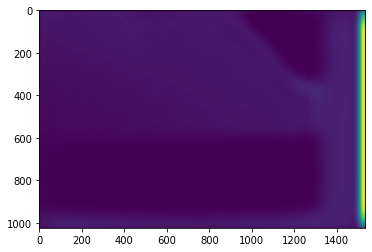

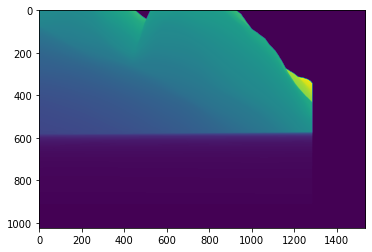

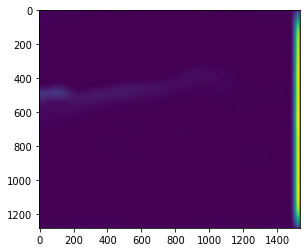

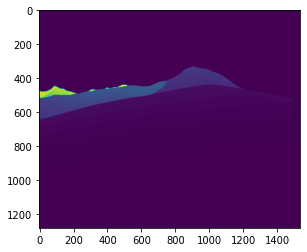

479405.0279947917
475377.306640625
473739.990234375
472555.10546875


In [ ]:
for epoch in range(100): 

  average_loss = 0

  for i_batch, sample_batched in enumerate(dataloader):
      images, depth_maps, shapes = sample_batched['images'], sample_batched['depth_maps'], sample_batched['shapes']
      
      output = model(images.to(device))
      depth_maps = depth_maps.to(device)
      
      optimizer.zero_grad()

      losses = []

      for pred, real, shape in zip(output.float(), depth_maps, shapes): 
          loss = criterion(pred[0, :shape[0], :shape[1]], real[:shape[0], :shape[1]])
          losses.append(loss)

      loss = sum(losses)
      loss.backward()
      optimizer.step()
      average_loss += loss.item()

      if epoch % 10 == 0:
        plt.imshow(output.cpu().detach().numpy()[0][0])
        plt.show()
        plt.imshow(depth_maps.cpu()[0])
        plt.show()

  print(average_loss/len(dataloader))